In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import umap
from keybert import KeyBERT
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import numpy as np
from matplotlib.patches import Ellipse
import ipywidgets as widgets
from IPython.display import display, clear_output

In [3]:
# Sample input
input_ideas = [
    "learn React", "JavaScript development", "jogging", "meditation", 
    "learn C#", "yoga", "run a marathon", "mindfulness", "backend development"
]

In [4]:
# Load spaCy model and stopwords
nlp = spacy.load("en_core_web_sm") # load english language model with tokenizer, PoS, lemmatizer and Named entity recognizer
stop_words = set(stopwords.words('english'))

# Step 0: Text Preprocessing

In [5]:
# Preprocessing: lowercasing, removing stopwords, lemmatization
def preprocess(texts):
    processed = []
    for text in texts:
        doc = nlp(text.lower()) # run NLP pipeline with lowercase text with added lemma_ and is_alpha
        # lemma example: "running" -> "run"
        # is_alpha stands for alphabetic characters

        # check in stop words and take only alphabetic characters
        tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.is_alpha]
        
        # rebuild string from tokens and append to processed list
        processed.append(" ".join(tokens))
    return processed

processed_ideas = preprocess(input_ideas)

# Step 1: SBERT embeddings

In [6]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(processed_ideas)

# Step 2: UMAP dimensionality reduction

In [7]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

/home/montare/miniconda3/envs/ml-research-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/montare/miniconda3/envs/ml-research-py310/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


# Step 3: KMeans clustering

In [8]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_2d)
cluster_labels

array([2, 1, 0, 0, 2, 1, 0, 0, 1], dtype=int32)

# Step 4: Cluster labeling with KeyBERT

In [ ]:
kw_model = KeyBERT(model=model)
cluster_texts = [[] for _ in range(n_clusters)]
for idx, label in enumerate(cluster_labels):
    cluster_texts[label].append(input_ideas[idx])

cluster_labels_text = []
for texts in cluster_texts:
    joined = ". ".join(texts)

    # ngram means we take 1-2 word combinations as a keyword
    # top n means we take the first keyword
    keywords = kw_model.extract_keywords(joined, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=1)
    
    # assign the first keyword to the cluster label
    label = keywords[0][0] if keywords else "Cluster"
    cluster_labels_text.append(label)

# Step 5: Simple 2D visualization

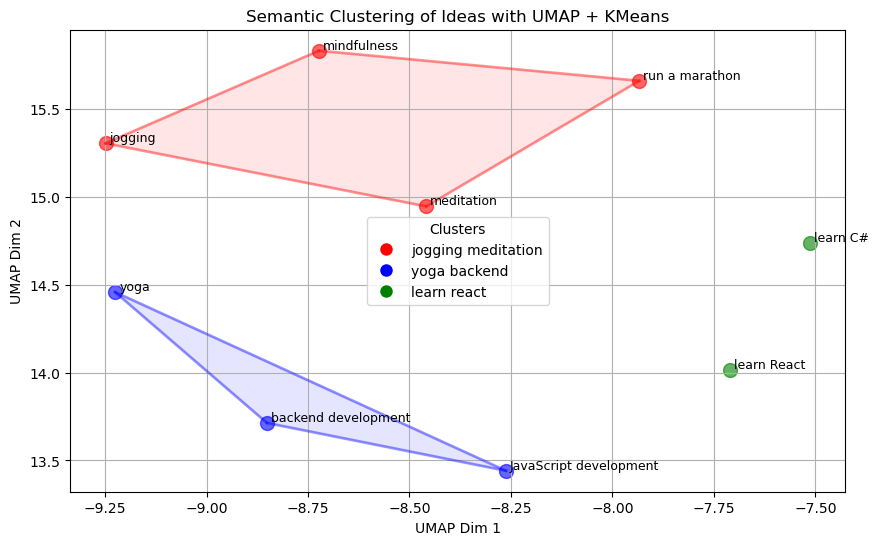

In [15]:


plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']
for i, (x, y) in enumerate(embedding_2d):
    label = cluster_labels[i]
    plt.scatter(x, y, color=colors[label], label=cluster_labels_text[label], s=100, alpha=0.6)
    plt.text(x + 0.01, y + 0.01, input_ideas[i], fontsize=9)

for label_idx in range(len(cluster_labels_text)):
    points = np.array([embedding_2d[i] for i in range(len(embedding_2d)) if cluster_labels[i] == label_idx])
    if len(points) >= 3:  # Convex hull needs at least 3 points
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1], color=colors[label_idx], linewidth=2, alpha=0.4)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], color=colors[label_idx], alpha=0.1)


# Create legend with cluster labels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                      markerfacecolor=color, markersize=10) 
           for label, color in zip(cluster_labels_text, colors)]
plt.legend(handles=handles, title="Clusters", loc="best")
plt.title("Semantic Clustering of Ideas with UMAP + KMeans")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.grid(True)
plt.show()
